# EfficientNet CNN

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

NOTE: the EfficientNetB0 model that I use in this notebook has trouble saving with some version of tensorflow (versions 2.10 and higher) <br>
I used the following fix to make it work on my machine (found in the comments here: https://github.com/keras-team/keras/issues/17199):

location: lib/python3.10/site-packages/keras/applications/efficientnet.py (py3.10) <br>
EDIT this: <br>
<code> x = layers.Rescaling(1.0 / tf.math.sqrt(IMAGENET_STDDEV_RGB))(x) </code> <br>
TO: <br>
<code> x = layers.Rescaling(
    [1.0 / math.sqrt(stddev) for stddev in IMAGENET_STDDEV_RGB]
)(x) </code>



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 

#tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img, smart_resize
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0

2023-06-10 14:14:21.064779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(123)
tf.random.set_seed(123)

I can use image_dataset_from_directory to load in the images.
Note that even though the images are grayscale, i have to use rgb color mode because that's the format EfficientNet requires

Let's look at the class names:

In [3]:
train_ds = image_dataset_from_directory('../img_data/train_symbols/', image_size=(100,100),
                                      batch_size=200, seed=123, validation_split=0.10,
                                       subset='training', labels ='inferred', color_mode='rgb', label_mode='categorical')  

val_ds = image_dataset_from_directory('../img_data/train_symbols/', image_size=(100,100),
                                      batch_size=200, seed=123, validation_split=0.10,
                                       subset='validation', labels ='inferred', color_mode='rgb', label_mode='categorical')  

Found 78792 files belonging to 100 classes.
Using 70913 files for training.


2023-06-09 04:39:47.663780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 78792 files belonging to 100 classes.
Using 7879 files for validation.


In [4]:
train_ds.class_names[:5]

['label_!', 'label_(', 'label_)', 'label_+', 'label_,']

I'll want to save these, so I can access them when it's time to make predictions

In [5]:
with open('../class_names.txt', 'w') as f:
    for i, label in enumerate(train_ds.class_names):
        f.write(str(i)+  ' ' + label + '\n')
        

Let's also look at the images that are loaded in by image_dataset_from_directory

In [6]:
img_list = []
for images, labels in train_ds.take(1):
    for i in range(30):
        img_list.append(images[i])

In [7]:
img_list[3].shape

TensorShape([100, 100, 3])

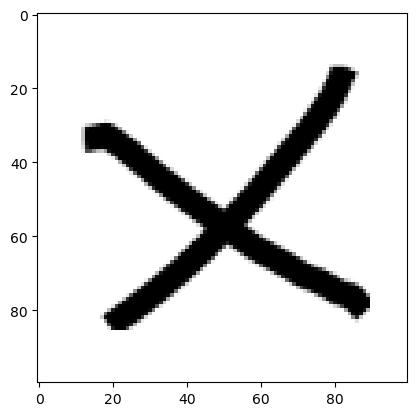

In [8]:
plt.imshow(img_list[4][:,:,0], cmap='gray');

That looks alright! It's important that the size of the symbols is roughtly similar to the symbol size out of the pre-processing pipeline.

Now we can set up the neural network. For optimal performance, I'll use the EfficientNetB0 network, and re-train it using my data

In [3]:
es = EarlyStopping(patience=5)

In [17]:
efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(100,100, 3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dropout(0.25))
model.add(Dense(units = 64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 100, activation='softmax'))
model.summary()


model.compile(
    optimizer=Adam(learning_rate = 0.0005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                81984     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 100)               6500      
                                                                 
Total params: 4,142,215
Trainable params: 4,100,192
No

Now we can fit:

In [18]:
h = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[es])

Epoch 1/30
355/355 [==============================] - 1185s 3s/step - loss: 1.2605 - accuracy: 0.7208 - val_loss: 0.3770 - val_accuracy: 0.9031
Epoch 2/30
355/355 [==============================] - 1249s 4s/step - loss: 0.3807 - accuracy: 0.9022 - val_loss: 0.2662 - val_accuracy: 0.9279
Epoch 3/30
355/355 [==============================] - 1275s 4s/step - loss: 0.2828 - accuracy: 0.9233 - val_loss: 0.2272 - val_accuracy: 0.9393
Epoch 4/30
355/355 [==============================] - 1249s 4s/step - loss: 0.2363 - accuracy: 0.9323 - val_loss: 0.2306 - val_accuracy: 0.9372
Epoch 5/30
355/355 [==============================] - 1124s 3s/step - loss: 0.2102 - accuracy: 0.9381 - val_loss: 0.2145 - val_accuracy: 0.9437
Epoch 6/30
355/355 [==============================] - 1111s 3s/step - loss: 0.1907 - accuracy: 0.9433 - val_loss: 0.2307 - val_accuracy: 0.9374
Epoch 7/30
355/355 [==============================] - 1214s 3s/step - loss: 0.1742 - accuracy: 0.9484 - val_loss: 0.1955 - val_accuracy:

We have an accuracy on the validation data of around 95%, which is pretty decent! Let's save the mdoe:

In [10]:
model_dir = '../CNN_model/'
if os.path.isdir(model_dir) == False: os.mkdir(model_dir)

In [19]:
model.save(model_dir + '/efficientnet_model_lw.h5')